In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install torch

In [ ]:
import numpy as np
import pandas as pd
import random

class PresentCipher:
    def __init__(self, key):
        self.rounds = 31
        self.block_size = 64
        self.key_size = 80
        self.key = self._expand_key(key)

    def _expand_key(self, key):
        key_state = np.uint64(key)
        keys = []
        for round in range(1, self.rounds + 2):
            keys.append(int(key_state) >> 16)
            key_state = ((key_state & np.uint64(0xFFFF)) << np.uint64(61)) | (key_state >> np.uint64(19))
            key_state = (key_state & np.uint64(0xFFFFFFFFFFFFFF00)) | (np.uint64(self._sbox(int(key_state >> np.uint64(76)))) << np.uint64(4)) | (key_state & np.uint64(0xF))
            key_state ^= (np.uint64(round) << np.uint64(15))
        return keys

    def _sbox(self, value):
        sbox = [0xC, 0x5, 0x6, 0xB, 0x9, 0x0, 0xA, 0xD, 0x3, 0xE, 0xF, 0x8, 0x4, 0x7, 0x1, 0x2]
        return sbox[value]

    def _pbox(self, value):
        pbox = [0, 16, 32, 48, 1, 17, 33, 49, 2, 18, 34, 50, 3, 19, 35, 51,
                4, 20, 36, 52, 5, 21, 37, 53, 6, 22, 38, 54, 7, 23, 39, 55,
                8, 24, 40, 56, 9, 25, 41, 57, 10, 26, 42, 58, 11, 27, 43, 59,
                12, 28, 44, 60, 13, 29, 45, 61, 14, 30, 46, 62, 15, 31, 47, 63]
        permuted = 0
        for i in range(self.block_size):
            if (value >> np.uint64(i)) & np.uint64(1):
                permuted |= (1 << pbox[i])
        return permuted

    def encrypt(self, block):
        state = np.uint64(block)
        for round_key in self.key[:-1]:
            state = np.uint64(state)
            round_key = np.uint64(round_key)
            state = state ^ round_key  # Use ^ for XOR operation
            state = self._sbox_layer(state)
            state = self._pbox(state)
        last_key = np.uint64(self.key[-1])
        state = int(state) ^ int(last_key)  # Use ^ for XOR operation
        return state

    def _sbox_layer(self, state):
        output = np.uint64(0)
        for i in range(self.block_size // 4):
            output |= (np.uint64(self._sbox((state >> np.uint64(i * 4)) & np.uint64(0xF))) << np.uint64(i * 4))
        return output

def differByOneBit(x, x_prime):
    return bin(int(x) ^ int(x_prime)).count('1') == 1

class Table:
    def __init__(self):
        self.data = []

    def AddToTable(self, y,y_prime, Class):
        self.data.append((y,y_prime, Class))

    def save(self, filename):
        df = pd.DataFrame(self.data, columns=['y','y_prime', 'Class'])
        df.to_csv(filename, index=False)

def generate_x_prime_class1(x):
    # Find one bit to flip in x
    bit_to_flip = random.randint(0, 63)
    return np.uint64(x) ^ np.uint64(1 << bit_to_flip)

def generate_x_prime_class2(x, used_values):
    while True:
        x_prime = np.random.randint(0, np.iinfo(np.uint64).max, dtype=np.uint64)
        if x_prime not in used_values and not differByOneBit(x, x_prime):
            return np.uint64(x_prime)
import random

def generate_distinct_64bit_numbers(n):
    numbers = set()

    while len(numbers) < n:
        number = random.getrandbits(64)
        numbers.add(number)

    return list(numbers)

# Example usage:



def main():
    num_count = 10000  # Change this to the number of distinct 64-bit numbers you need
    distinct_64bit_numbers = generate_distinct_64bit_numbers(num_count)
    key = np.random.randint(0, np.iinfo(np.uint64).max, dtype=np.uint64)
    present_cipher = PresentCipher(key)
    # Create a binary string with 63 zeros followed by a 1
    binary_string = '0' * 63 + '1'

    # Convert the binary string to an integer
    delx_related = int(binary_string, 2)

    table = Table()
    used_values = set()

    for i in distinct_64bit_numbers:
        # Generate x_prime for Class1
        x_prime_class1 = i^delx_related
        y = present_cipher.encrypt(i)
        y_prime_class1 = present_cipher.encrypt(x_prime_class1)
        table.AddToTable(y,y_prime_class1, 1)
        used_values.add(x_prime_class1)

        # Generate x_prime for Class2
        x_prime_class2 = generate_x_prime_class2(i, used_values)
        y_prime_class2 = present_cipher.encrypt(x_prime_class2)
        del_y_class2 = y ^ y_prime_class2
        table.AddToTable(y,y_prime_class2, 2)
        used_values.add(x_prime_class2)

    table.save('drdo.csv')

if __name__ == '__main__':
    main()

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drdo.csv')
# Convert the data to tensors
data=pd.DataFrame(data,columns=['y','y_prime','Class'])
data["Class"] = data["Class"].replace([1], 0)
data["Class"] = data["Class"].replace([2], 1)
display(data)


,y,y_prime,Class
0,11756570676014492809,17352044316602710776,0
1,11756570676014492809,10526054729024172057,1
2,11462238541805127359,1072635588684368230,0
3,11462238541805127359,10872296617810697308,1
4,14862994198189228099,18289275764776805518,0
...,...,...,...
19995,17926239593628952494,17164768060539061455,1
19996,14763695812154035514,7523508971787712577,0
19997,14763695812154035514,8192082567525941846,1
19998,3364316087322570316,4606166183231404305,0


Basic Information of the Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   y        20000 non-null  uint64
 1   y_prime  20000 non-null  uint64
 2   Class    20000 non-null  int64 
dtypes: int64(1), uint64(2)
memory usage: 468.9 KB
None

Descriptive Statistics:
                  y       y_prime         Class
count  2.000000e+04  2.000000e+04  20000.000000
mean   9.123569e+18  9.267766e+18      0.500000
std    5.364668e+18  5.320888e+18      0.500013
min    2.227426e+15  1.595287e+15      0.000000
25%    4.437595e+18  4.668334e+18      0.000000
50%    9.101349e+18  9.285572e+18      0.500000
75%    1.375473e+19  1.389732e+19      1.000000
max    1.844653e+19  1.844655e+19      1.000000

Missing Values in the Dataset:
y          0
y_prime    0
Class      0
dtype: int64

Class Distribution:
Class
0    10000
1    10000
Name: count, dtype: int64


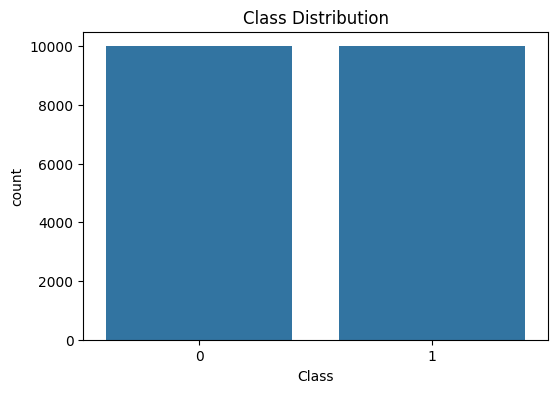

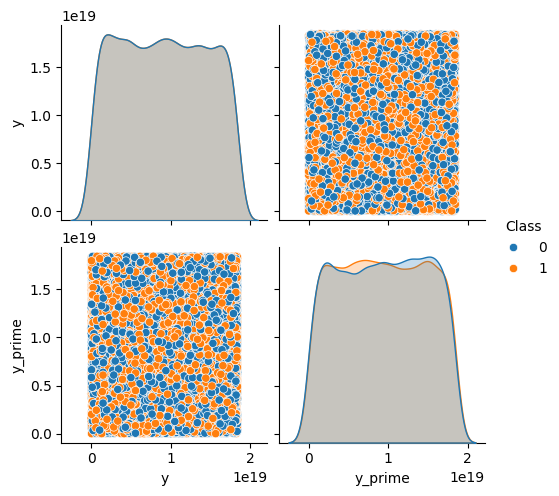


Correlation Matrix:
                    y   y_prime         Class
y        1.000000e+00 -0.011663 -5.821941e-19
y_prime -1.166259e-02  1.000000 -1.785714e-03
Class   -5.821941e-19 -0.001786  1.000000e+00


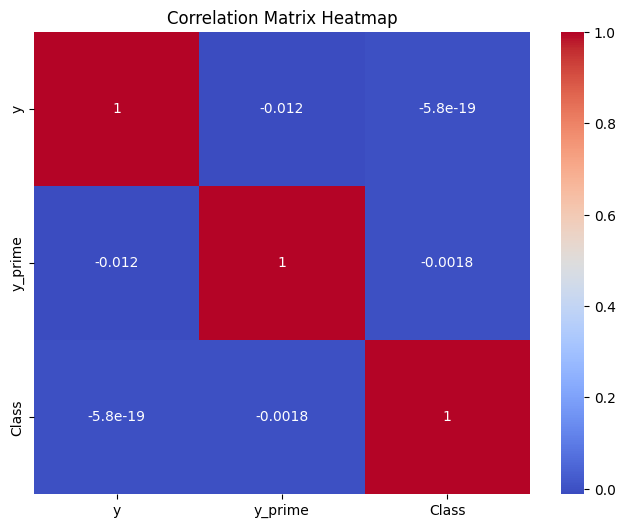

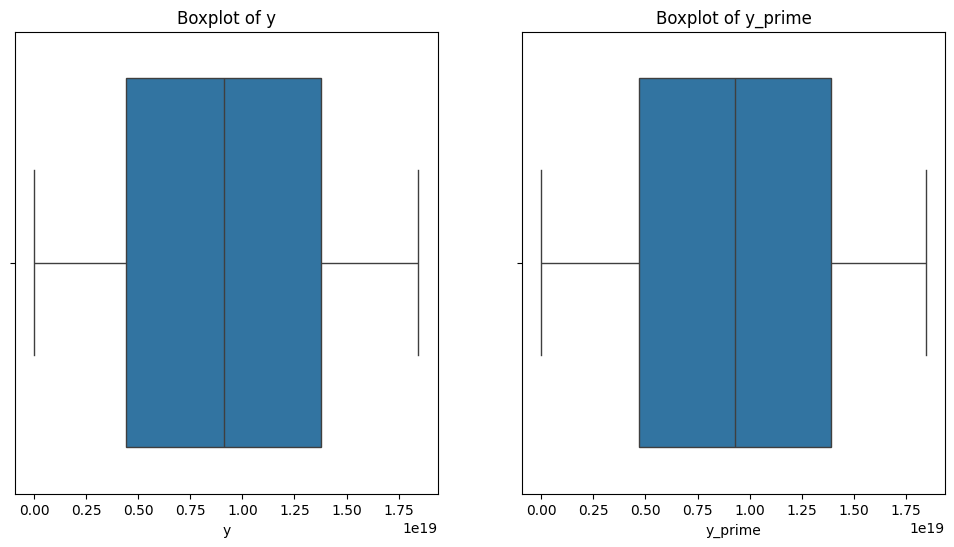

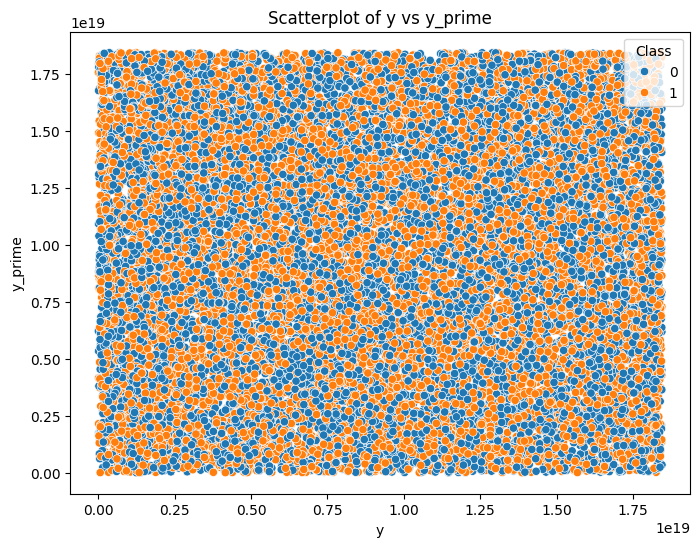

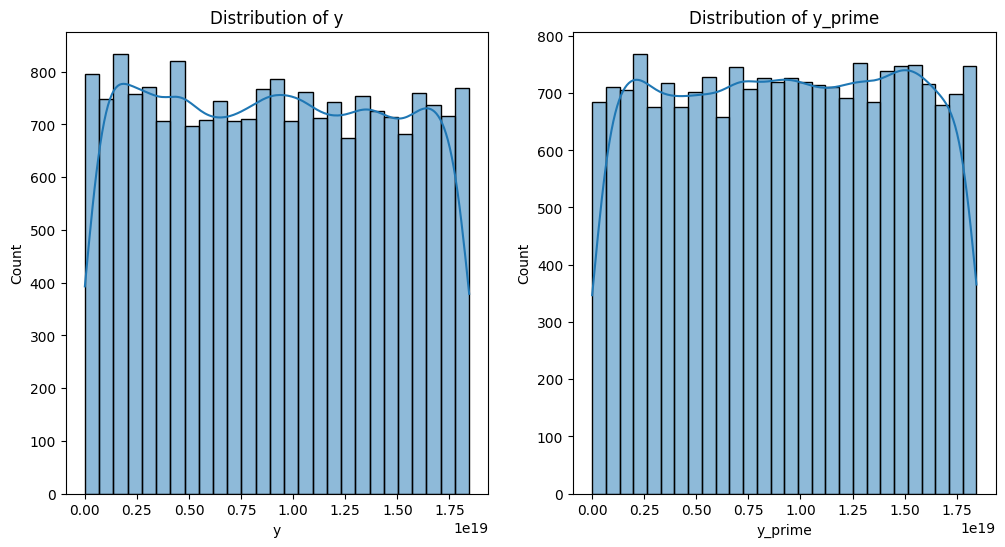

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Basic Information
print("Basic Information of the Dataset:")
print(data.info())

# Descriptive Statistics
print("\nDescriptive Statistics:")
print(data.describe())

# Checking for Missing Values
print("\nMissing Values in the Dataset:")
print(data.isnull().sum())

# Class Distribution
print("\nClass Distribution:")
print(data['Class'].value_counts())

# Plotting Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.show()

# Pairplot to visualize the relationship between features
sns.pairplot(data, hue='Class')
plt.show()

# Correlation Matrix
correlation_matrix = data.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Heatmap of Correlation Matrix
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Boxplot for Outlier Detection
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.boxplot(x=data['y'])
plt.title('Boxplot of y')

plt.subplot(1, 2, 2)
sns.boxplot(x=data['y_prime'])
plt.title('Boxplot of y_prime')
plt.show()

# Scatterplot for Outlier Detection
plt.figure(figsize=(8,6))
sns.scatterplot(x='y', y='y_prime', hue='Class', data=data)
plt.title('Scatterplot of y vs y_prime')
plt.show()

# Distribution Plots
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.histplot(data['y'], kde=True)
plt.title('Distribution of y')

plt.subplot(1, 2, 2)
sns.histplot(data['y_prime'], kde=True)
plt.title('Distribution of y_prime')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


# Assuming the CSV file has columns 'y', 'y_prime', 'Class'
X = data[['y', 'y_prime']]
y = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Define and train the feed-forward neural network model
nn_model = Sequential([
    Dense(128, input_dim=2, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)




train_loss, train_accuracy = nn_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = nn_model.evaluate(X_test, y_test, verbose=0)

y_pred_prob = nn_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
nn_precision = precision_score(y_test, y_pred)

# For collecting model results
results = []

# Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, y_pred)
log_reg_precision = precision_score(y_test, y_pred)
results.append(('Logistic Regression', log_reg_accuracy, log_reg_precision))

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred)
dt_precision = precision_score(y_test, y_pred)
results.append(('Decision Tree', dt_accuracy, dt_precision))

# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
results.append(('Random Forest', rf_accuracy, rf_precision))

# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred)
gb_precision = precision_score(y_test, y_pred)
results.append(('Gradient Boosting', gb_accuracy, gb_precision))

# SVM
from sklearn.svm import SVC

svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
results.append(('SVM', svm_accuracy, svm_precision))

# KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)
knn_precision = precision_score(y_test, y_pred)
results.append(('KNN', knn_accuracy, knn_precision))

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_precision = precision_score(y_test, y_pred)
results.append(('XGBoost', xgb_accuracy, xgb_precision))

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier()
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
lgb_accuracy = accuracy_score(y_test, y_pred)
lgb_precision = precision_score(y_test, y_pred)
results.append(('LightGBM', lgb_accuracy, lgb_precision))



# Adding Neural Network results
results.append(('Feed Forward Neural Network', test_accuracy, nn_precision))

# Creating DataFrame and displaying the results
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision'])
print(results_df)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:36:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 7994, number of negative: 8006
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499625 -> initscore=-0.001500
[LightGBM] [Info] Start training from score -0.001500
                         Model  Accuracy  Precision
0          Logistic Regression   0.49125   0.492192
1                Decision Tree   0.50700   0.508374
2                Random Forest   0.48675   0.488221
3            Gradient Boosting   0.48900   0.488902
4                          SVM   0.49350   0.494970
5                          KNN   0.50400   0.505500
6                      XGBoost   0.48725   0.488710
7                     LightGBM   0.48650   0.488189
8  Feed Forward Neural Network   0.49850  

In [ ]:
!pip install ydata-profiling # install the correct package

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 77.5 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=66a1a66b5751cd43a1626f2b903e1033085a10f690caf8b1fc9b258d2ab36df6
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:39:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 7994, number of negative: 8006
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499625 -> initscore=-0.001500
[LightGBM] [Info] Start training from score -0.001500
Reports generated: EDA_Report.html and ML_Results_Report.html


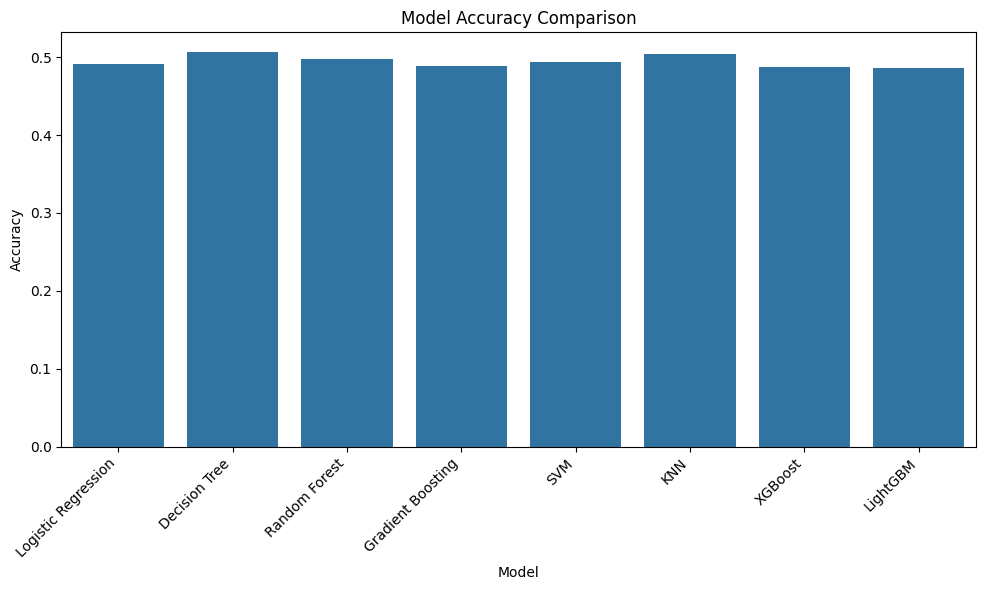

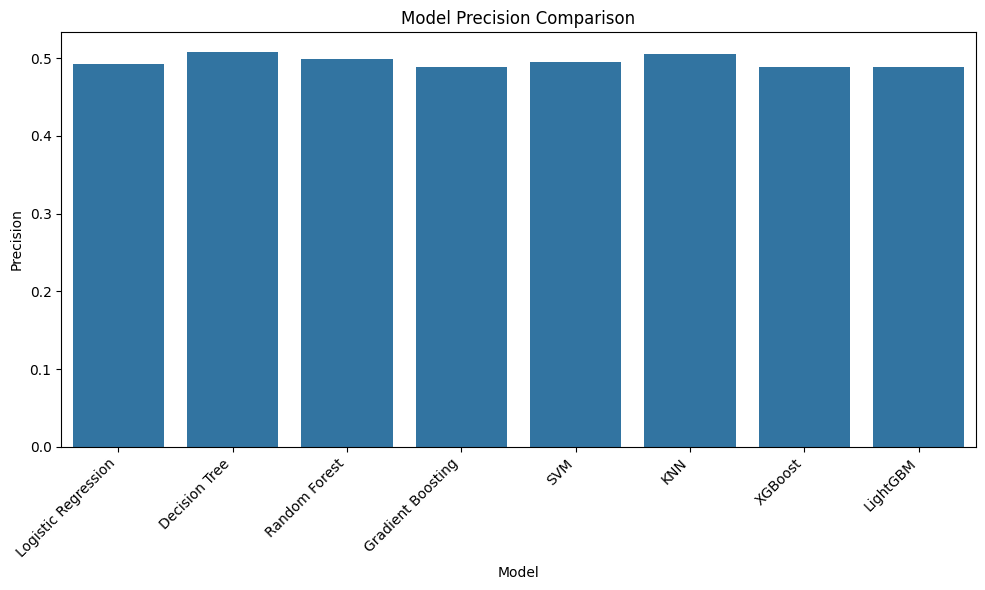

In [ ]:

import pandas as pd
from ydata_profiling import ProfileReport # import from the correct package
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Load the dataset
data = pd.read_csv('/content/drdo.csv')  # Replace 'your_dataset.csv' with the actual file name
data=pd.DataFrame(data,columns=['y','y_prime','Class'])
data["Class"] = data["Class"].replace([1], 0)
data["Class"] = data["Class"].replace([2], 1)

# Generate the EDA report using pandas-profiling
profile = ProfileReport(data, title="EDA Report for Your Dataset", explorative=True)
profile.to_file("EDA_Report.html")

# --- Machine Learning Model Training and Evaluation ---

# Assuming the CSV file has columns 'y', 'y_prime', 'Class'
X = data[['y', 'y_prime']]
y = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# For collecting model results
results = []

# Train and evaluate different models
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('SVM', SVC()),
    ('KNN', KNeighborsClassifier()),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('LightGBM', LGBMClassifier()),
]

for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    results.append((model_name, accuracy, precision))

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision'])

# --- Generate a Report of the Results ---

# Create a report with a table and visualizations
with open('ML_Results_Report.html', 'w') as f:
    f.write('<h1>Machine Learning Model Results</h1>')

    # Table of results
    f.write(results_df.to_html())

    # Visualization of results
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Accuracy', data=results_df)
    plt.xticks(rotation=45, ha='right')
    plt.title('Model Accuracy Comparison')
    plt.tight_layout()
    plt.savefig('accuracy_comparison.png')
    f.write('<br><img src="accuracy_comparison.png">')

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Precision', data=results_df)
    plt.xticks(rotation=45, ha='right')
    plt.title('Model Precision Comparison')
    plt.tight_layout()
    plt.savefig('precision_comparison.png')
    f.write('<br><img src="precision_comparison.png">')

    f.close()

print("Reports generated: EDA_Report.html and ML_Results_Report.html")

In [ ]:
profile.to_notebook_iframe()